In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import numpy as np

from sparcscore.pipeline.project import Project
from sparcscore.pipeline.workflows import CytosolSegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction
from sparcscore.pipeline.classification import CellFeaturizer
from sparcscore.pipeline.selection import LMDSelection

In [4]:
project_location = f"project"

project = Project(os.path.abspath(project_location),
                  config_path= "config_example2.yml",
                  overwrite=True,
                  debug=True,
                  segmentation_f=CytosolSegmentationCellpose,
                  extraction_f=HDF5CellExtraction,
                  classification_f=CellFeaturizer,
                  selection_f=LMDSelection
                  )

modifying config
[12/07/2024 15:40:41] Loading config from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/config.yml
[12/07/2024 15:40:41] Loading classes from default classes path: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/segmentation/classes.csv
[12/07/2024 15:40:41] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data
[12/07/2024 15:40:41] current run: 0


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/project.py:152: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


In [5]:
#these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = ["./input_images/ch1.tif",
          "./input_images/ch2.tif",
          "./input_images/ch3.tif"]

project.load_input_from_file(images)

[12/07/2024 15:40:43] Overwrite is set to True. Existing input image was deleted.
[12/07/2024 15:40:43] saved input_image: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/input_image.ome.zarr


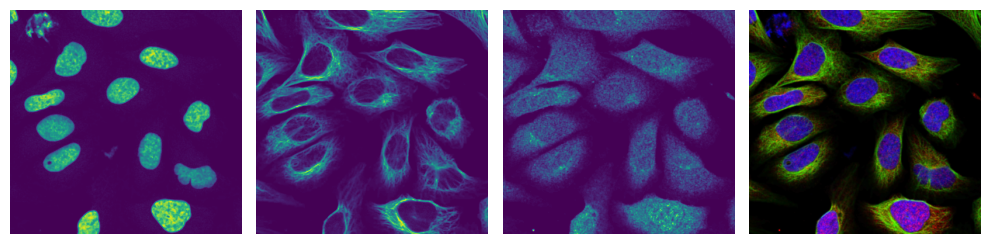

In [6]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color

def generate_composite(images, colors = [(0, 0, 1),(0, 1, 0), (1, 0, 0), (1, 0, 1)], plot = False):
    colorized = []
    for image, color in zip(images, colors):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized)-1):
        image += colorized[i+1]

    return(np.clip(image, 0, 1))

fig, axs = plt.subplots(1, 4, figsize = (10, 4));
axs[0].imshow(project.input_image[0]);
axs[0].axis("off");

axs[1].imshow(project.input_image[1]);
axs[1].axis("off");

axs[2].imshow(project.input_image[2]);
axs[2].axis("off");

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off");

fig.tight_layout()

[12/07/2024 15:40:47] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolSegmentationCellpose_qlrc33ks for CytosolSegmentationCellpose
[12/07/2024 15:40:47] running on default GPU.
[12/07/2024 15:40:47] Using MPS backend for segmentation.
[12/07/2024 15:40:47] GPU Status for segmentation: True
[12/07/2024 15:40:47] Segmenting nuclei using the following model: nuclei
[12/07/2024 15:40:48] Segmenting cytosol using the following model: cyto2
[12/07/2024 15:40:49] Filtering generated nucleus and cytosol masks based on size.
[12/07/2024 15:40:49] No confidence interval specified for nucleus mask filtering, using default value of 0.95
[12/07/2024 15:40:49] Automatically calculating thresholds for filtering of nuclei based on a fitted normal distribution with a confidence interval of 95.0%.
[12/07/2024 15:40:49] Removed 2 nuclei as they fell outside of the threshold range [ 245.85191761 3013.95066282].
[12/07/2024 15:40:49] No confidence interval spec

/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/workflows.py:994: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[12/07/2024 15:40:50] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolSegmentationCellpose_qlrc33ks'>


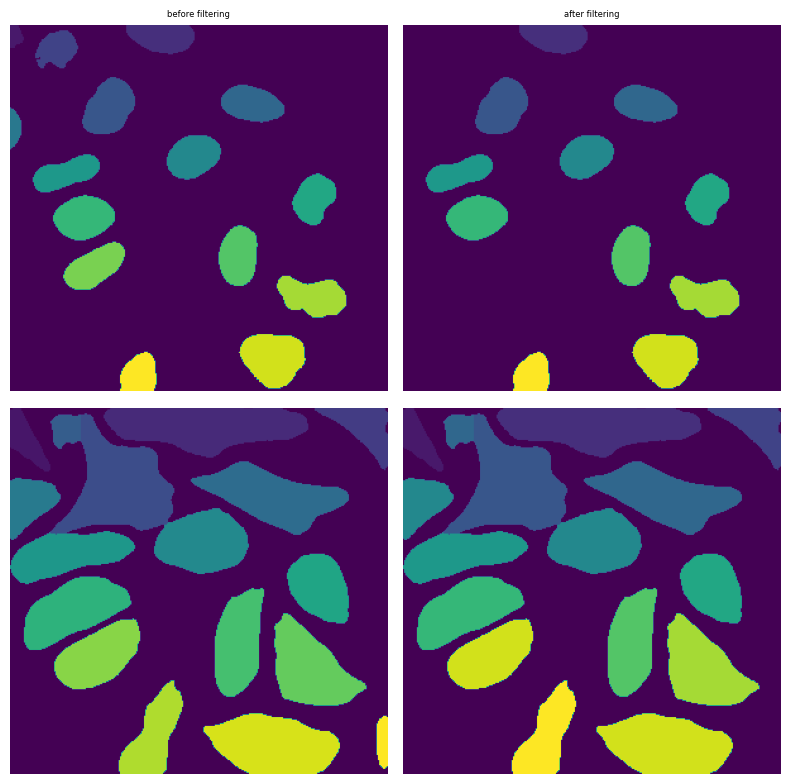

In [7]:
project.segment()

<HDF5 dataset "labels": shape (2, 290, 299), type "<u4">


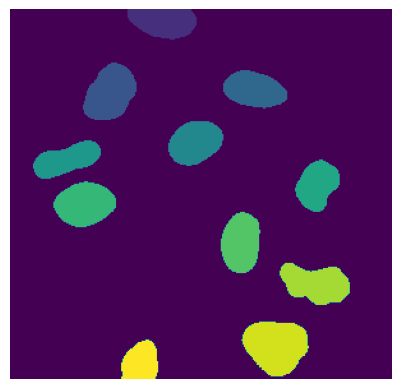

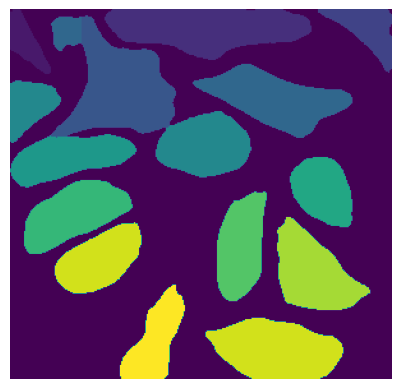

In [8]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")
    print(segmentation)

    plt.figure()
    plt.imshow(segmentation[0])
    plt.axis("off")

    plt.figure()
    plt.imshow(segmentation[1])
    plt.axis("off")

In [9]:
project.extract()

[12/07/2024 15:40:50] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_0st7vwm0 for HDF5CellExtraction
[12/07/2024 15:40:50] Using channel label <HDF5 dataset "channels": shape (3, 290, 299), type "<u2">
[12/07/2024 15:40:50] Using segmentation label <HDF5 dataset "labels": shape (2, 290, 299), type "<u4">
[12/07/2024 15:40:50] Created new data directory /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data
[12/07/2024 15:40:50] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data
[12/07/2024 15:40:50] Started extraction
[12/07/2024 15:40:50] Loading segmentation data from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/segmentation/segmentation.h5
[12/07/2024 15:40:50] Finished loading channel data (3, 290, 299)
[12/07/2024 15:40:50] Finished loading label data (2, 290, 299)
[12/07/2024 15:40:50] Started

/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/extraction.py:652: RuntimeWarning: invalid value encountered in cast
  px_centers = np.round(center_nuclei).astype(int)


cell id 8 is too close to the image edge to extract. Skipping this cell.cell id 14 is too close to the image edge to extract. Skipping this cell.[12/07/2024 15:40:52] Extracting dataset 0cell id 15 is too close to the image edge to extract. Skipping this cell.

Processing cell batches:   0%|          | 0/11 [00:00<?, ?it/s]





cell id 2 is too close to the image edge to extract. Skipping this cell.
multiprocessing done.
[12/07/2024 15:40:52] Finished extraction in 0.50 seconds (21.91 cells / second)
[12/07/2024 15:40:52] Transferring results to final HDF5 data container.
[12/07/2024 15:40:52] number of cells too close to image edges to extract: 4
[12/07/2024 15:40:52] Transferring extracted single cells to .hdf5
[12/07/2024 15:40:52] index created.
[12/07/2024 15:40:52] Finished cleaning up cache.
[12/07/2024 15:40:52] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_0st7vwm0'>


(7, 5, 110, 110)


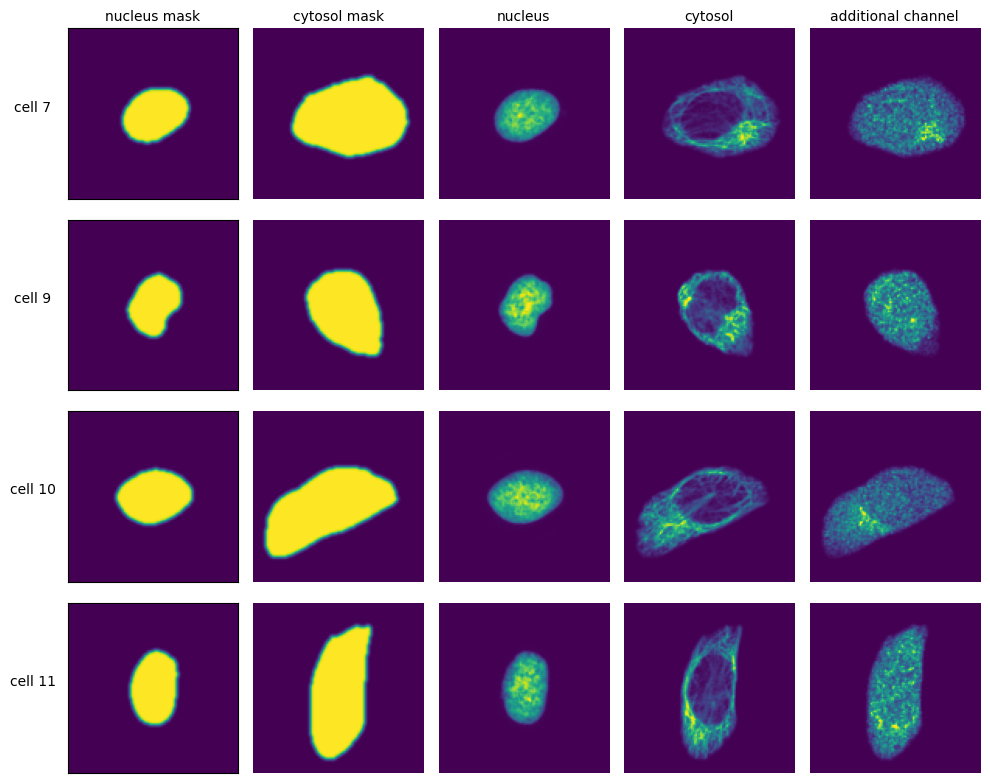

In [10]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize = (5*2, len(n_cells)*2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]
    
    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()

In [11]:
project.classify(accessory = [(), (), ()])

[12/07/2024 15:40:53] Started classification
[12/07/2024 15:40:53] starting with run 0
[12/07/2024 15:40:53] channel_classification: 4
[12/07/2024 15:40:53] batch_size: 900
[12/07/2024 15:40:53] dataloader_worker_number: 0
[12/07/2024 15:40:53] inference_device: cpu
[12/07/2024 15:40:53] screen_label: Ch3_Featurization
[12/07/2024 15:40:53] 0 different accessory datasets specified
[12/07/2024 15:40:53] loading /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data
[12/07/2024 15:40:53] Adding hdf5 file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data/single_cells.h5 to index...
Total: 7
0: 7

[12/07/2024 15:40:53] start processing 1 batches
[12/07/2024 15:40:53] finished processing


/Users/sophia/mambaforge/envs/SPARCSspatial-dev/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [13]:
#load classification results
results = pd.read_csv(f"{project_location}/classification/0_Ch3_Featurization/calculated_features.csv", index_col = 0)
results

,nucleus_area,cytosol_area,mean,median,quant75,quant25,summed_intensity_nucleus_area,summed_intensity_cytosol_area,summed_intensity_nucleus_area_normalized,summed_intensity_cytosol_area_normalized,label,cell_id
0,1820.0,3528.0,0.086362,0.0,0.000142,0.0,770.60187,1044.98390,0.423408,0.296197,0,11
1,1746.0,4319.0,0.104887,0.0,0.086365,0.0,762.88720,1269.12980,0.436934,0.293848,0,5
2,1768.0,3841.0,0.078138,0.0,0.018894,0.0,633.94464,945.47424,0.358566,0.246153,0,7
3,2043.0,6251.0,0.113089,0.0,0.203369,0.0,773.35376,1368.37320,0.378538,0.218905,0,4
4,1972.0,4059.0,0.072553,0.0,0.031155,0.0,556.04120,877.89610,0.281968,0.216284,0,10
5,1586.0,2841.0,0.062852,0.0,0.000000,0.0,630.32820,760.51430,0.397433,0.267692,0,9
6,2014.0,4259.0,0.069664,0.0,0.071228,0.0,539.81070,842.93414,0.268029,0.197918,0,13
